傾向スコアを利用した因果推論　ー　マッチング、逆確率重み付き推定

安井翔太、（株）ホクソエム『効果検証入門』で紹介されているLaLonde(1986)のテストデータを使用し、傾向スコアマッチング及び逆確率重み付き推定のテストを実施。

（参考）
https://qiita.com/chicken_data_analyst/items/7e1d231ad0ada4ffda8d

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from tqdm import tqdm

cps = pd.read_stata('https://users.nber.org/~rdehejia/data/cps_controls.dta')
nsw = pd.read_stata('https://users.nber.org/~rdehejia/data/nsw_dw.dta')
display(cps.head())
display(nsw.head())

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,CPS1,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.669922,25243.550781,25564.669922
1,CPS1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.970947,5852.564941,13496.080078
2,CPS1,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.019531,25130.759766,25564.669922
3,CPS1,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.369141,25243.550781,25564.669922
4,CPS1,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295044,10727.610352,9860.869141


,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


In [2]:
tr = 'treat'
al = ['age','education','black','hispanic','married','nodegree','re74','re75','re78']
vl = ['age','education','black','hispanic','married','nodegree','re74','re75']
nsw_plus_cps = pd.concat([nsw[nsw[tr] == 1], cps]) 

display(nsw_plus_cps)
display(nsw_plus_cps.treat.value_counts())

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,0.000000,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.000000,0.000000,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.000000,0.000000,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.000000,0.000000,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.000000,0.000000,289.789886
...,...,...,...,...,...,...,...,...,...,...,...
15987,CPS1,0.0,22.0,12.0,1.0,0.0,0.0,0.0,3975.352051,6801.435059,2757.437988
15988,CPS1,0.0,20.0,12.0,1.0,0.0,1.0,0.0,1445.938965,11832.240234,6895.071777
15989,CPS1,0.0,37.0,12.0,0.0,0.0,0.0,0.0,1733.951050,1559.370972,4221.865234
15990,CPS1,0.0,47.0,9.0,0.0,0.0,1.0,1.0,16914.349609,11384.660156,13671.929688


0.0    15992
1.0      185
Name: treat, dtype: int64

In [3]:
#傾向スコア計算：Logistic Model
def propscore(std_X, y):
    score = LogisticRegression(
        max_iter = 10000,  #最大収束回数
        C = 500            #正則化の強さの逆数
    ) 
    score.fit(std_X, y)
    pred = score.predict(std_X)
    pred_proba = score.predict_proba(std_X)  #クラスの分類確率
    return score, pred, pred_proba[:,1]

In [4]:
X = nsw_plus_cps[vl].copy()  #参照渡し->値渡し
y = nsw_plus_cps[tr].copy()
std_X = sk.preprocessing.StandardScaler().fit_transform(X)  #標準化
propscore, pred, pred_proba = propscore(std_X, y)

display(propscore)   #
display(pred)        #
display(pred_proba)  #傾向スコア

LogisticRegression(C=500, max_iter=10000)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

array([2.47502524e-01, 7.25734510e-02, 2.50392163e-01, ...,
       3.29947976e-03, 2.40844272e-04, 5.22379985e-04])

In [5]:
nsw_plus_cps['id'] = range(len(nsw_plus_cps))  #連番
nsw_plus_cps['Zscore'] = pred_proba            #傾向スコア
nsw_plus_cps = nsw_plus_cps[['id', tr, 'Zscore'] + al]

nsw_plus_cps.head()

,id,treat,Zscore,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,0,1.0,0.247503,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,1,1.0,0.072573,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,2,1.0,0.250392,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,3,1.0,0.478942,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,4,1.0,0.447516,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


In [6]:
#傾向スコアマッチング関数
def matching(dat, z = 'Zscore', tr = 'fg', match_id = 'id'):
    #傾向スコアのキャリパー：標準0.2SD
    caliper = nsw_plus_cps[z].std() * 0.2
    #処置群抽出
    treat = nsw_plus_cps[nsw_plus_cps[tr] > 0][[match_id, z]].copy()
    treat.index = treat[match_id]
    #対照群抽出
    control = nsw_plus_cps[nsw_plus_cps[tr] == 0][[match_id, z]].copy()
    control.index = control[match_id]
    #配列化
    control_vl = np.copy(control[z].to_numpy())
    control_id = np.copy(control.index.to_numpy())
    #処置群の傾向スコアで降順にして辞書化
    treat_vl_dict = treat[z].sort_values(ascending = False).to_dict() 
    
    #Matching
    match = []
    for i, (cid, tr_vl) in tqdm(enumerate(treat_vl_dict.items())):
        #cid:id, treat_vl:傾向スコア
        #argminで処置群と最も傾向スコアの差が小さい対照群のインデックス番号取得
        near_id = np.abs(control_vl - tr_vl).argmin()
        #傾向スコアの差がキャリパーより大きかった場合、マッチングしない
        if np.abs(tr_vl - control_vl[near_id]) > caliper: continue
        #傾向スコアの差がキャリパーより小さかった場合、マッチングした者同士をリストに格納
        match.append([cid, control_id[near_id], tr_vl, control_vl[near_id]])
        #次のマッチングで重複してマッチングしないように対照群のスコアを-9999に置き換える
        np.put(control_vl, [near_id], -9999)
    
    match_df = pd.DataFrame(match, columns = ['tr', 'control', 'tr_Zscore', 'ct_Zscore'])
    match_df['diff'] = np.abs(match_df['tr_Zscore'] - match_df['ct_Zscore'])
    print(match_df['diff'].max())
    return match_df

In [7]:
match_df = matching(nsw_plus_cps, z = 'Zscore', tr = 'treat', match_id = 'id')
display(match_df)

185it [00:00, 6868.85it/s]

0.010787701824319873


,tr,control,tr_Zscore,ct_Zscore,diff
0,52,2781,0.487435,0.487435,0.000000e+00
1,103,7777,0.487435,0.487435,0.000000e+00
2,104,2768,0.486491,0.486491,0.000000e+00
3,44,7776,0.485547,0.486491,9.440277e-04
4,79,11530,0.483659,0.484403,7.432535e-04
...,...,...,...,...,...
178,176,7807,0.002528,0.002526,2.798664e-06
179,9,865,0.001825,0.001825,0.000000e+00
180,123,5455,0.001226,0.001227,4.810019e-07
181,184,3488,0.001059,0.001060,6.636567e-08


In [8]:
X = sm.add_constant(nsw[vl + [tr]]) #全要素が1.0の列を先頭に追加
model = sm.OLS(nsw['re78'], X)
estim = model.fit()
print(estim.summary())

'''
#statsmodelでは、切片を必要とする線形回帰のモデル式の場合、全要素が1.0の列を説明変数の先頭に追加する必要がある
'''

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.804
Date:                Wed, 08 Feb 2023   Prob (F-statistic):            0.00329
Time:                        21:12:46   Log-Likelihood:                -4534.2
No. Observations:                 445   AIC:                             9088.
Df Residuals:                     435   BIC:                             9129.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        785.0614   3374.969      0.233      0.8

'\n#statsmodelでは、切片を必要とする線形回帰のモデル式の場合、全要素が1.0の列を説明変数の先頭に追加する必要がある\n'

In [9]:
X = sm.add_constant(nsw_plus_cps[vl + [tr]])
model = sm.OLS(nsw_plus_cps['re78'], X)
estim = model.fit()
print(estim.summary())

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     1631.
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:12:46   Log-Likelihood:            -1.6618e+05
No. Observations:               16177   AIC:                         3.324e+05
Df Residuals:                   16167   BIC:                         3.325e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5735.7312    445.176     12.884      0.0

In [10]:
match_nsw_plus_cps = nsw_plus_cps.copy()
match_nsw_plus_cps['id'] = range(len(nsw_plus_cps))
match_nsw_plus_cps = match_nsw_plus_cps[(match_nsw_plus_cps['id'].isin(match_df['control'].unique())) | (match_nsw_plus_cps['id'].isin(match_df['tr'].unique()))].copy()

match_nsw_plus_cps.tail()

,id,treat,Zscore,age,education,black,hispanic,married,nodegree,re74,re75,re78
15169,15354,0.0,0.222595,45.0,10.0,1.0,0.0,0.0,1.0,4200.667969,4443.581055,8872.269531
15437,15622,0.0,0.000701,23.0,14.0,0.0,0.0,0.0,0.0,6136.423828,8853.144531,8588.546875
15638,15823,0.0,0.162152,24.0,13.0,1.0,0.0,0.0,0.0,0.000000,2848.403076,12046.429688
15887,16072,0.0,0.123876,35.0,7.0,1.0,0.0,0.0,1.0,8015.359863,6937.500000,5071.558105
15917,16102,0.0,0.462210,17.0,9.0,1.0,0.0,0.0,1.0,1222.582031,0.000000,422.629791


In [11]:
X = sm.add_constant(match_nsw_plus_cps[vl + [tr]])
model = sm.OLS(match_nsw_plus_cps['re78'], X)
estim = model.fit()
print(estim.summary())

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     2.282
Date:                Wed, 08 Feb 2023   Prob (F-statistic):             0.0169
Time:                        21:12:46   Log-Likelihood:                -3745.7
No. Observations:                 366   AIC:                             7511.
Df Residuals:                     356   BIC:                             7550.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -107.9903   3529.110     -0.031      0.9

,id,treat,Zscore,age,education,black,hispanic,married,nodegree,re74,re75,re78,weight
0,0,1.0,0.247503,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898,4.040363
1,1,1.0,0.072573,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043,13.779144
2,2,1.0,0.250392,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219,3.993735
3,3,1.0,0.478942,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996,2.087935
4,4,1.0,0.447516,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886,2.234559


,id,treat,Zscore,age,education,black,hispanic,married,nodegree,re74,re75,re78,weight
0,185,0.0,0.000012,45.0,11.0,0.0,0.0,1.0,1.0,21516.669922,25243.550781,25564.669922,1.000012
1,186,0.0,0.001454,21.0,14.0,0.0,0.0,0.0,0.0,3175.970947,5852.564941,13496.080078,1.001456
2,187,0.0,0.000004,38.0,12.0,0.0,0.0,1.0,0.0,23039.019531,25130.759766,25564.669922,1.000004
3,188,0.0,0.000009,48.0,6.0,0.0,0.0,1.0,1.0,24994.369141,25243.550781,25564.669922,1.000009
4,189,0.0,0.000466,18.0,8.0,0.0,0.0,1.0,1.0,1669.295044,10727.610352,9860.869141,1.000466


(array([1.5481e+04, 1.8800e+02, 1.1300e+02, 3.9000e+01, 7.7000e+01,
        8.9000e+01, 2.6000e+01, 1.5000e+01, 4.1000e+01, 1.0800e+02]),
 array([3.76751278e-06, 4.88413285e-02, 9.76788894e-02, 1.46516450e-01,
        1.95354011e-01, 2.44191572e-01, 2.93029133e-01, 3.41866694e-01,
        3.90704255e-01, 4.39541816e-01, 4.88379377e-01]),
 <a list of 10 Patch objects>)

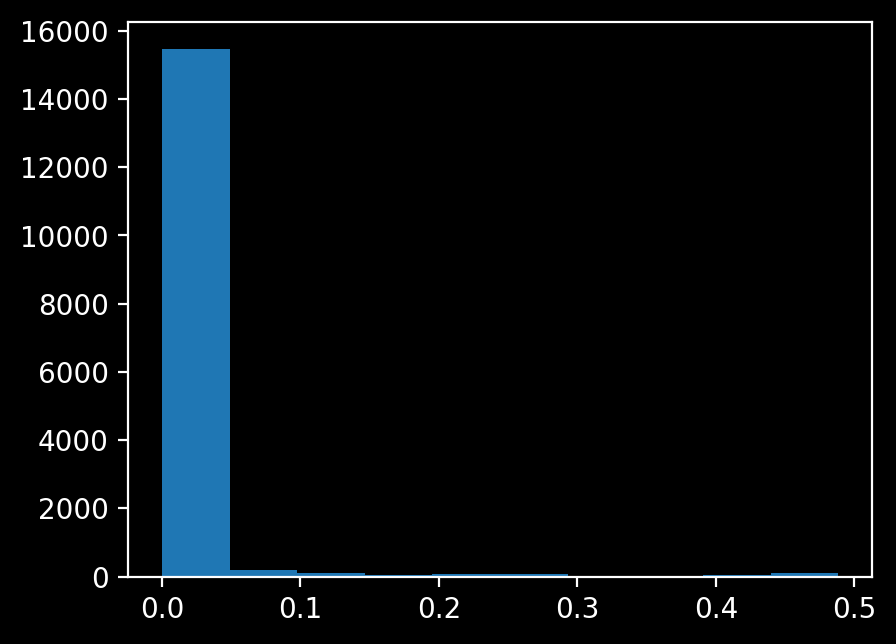

In [12]:
nsw_plus_cps['weight'] = nsw_plus_cps['treat']/nsw_plus_cps['Zscore'] + (1-nsw_plus_cps['treat'])/(1-nsw_plus_cps['Zscore'])

display(nsw_plus_cps[nsw_plus_cps['treat'] > 0].head())
display(nsw_plus_cps[nsw_plus_cps['treat'] == 0].head())
plt.hist(nsw_plus_cps['Zscore'])

In [13]:
X = sm.add_constant(nsw_plus_cps[vl + [tr]])
model = sm.WLS(nsw_plus_cps['re78'], X, weights = nsw_plus_cps['weight'])
estim = model.fit()
print(estim.summary())

                            WLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.451
Model:                            WLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     1476.
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:12:46   Log-Likelihood:            -1.6921e+05
No. Observations:               16177   AIC:                         3.384e+05
Df Residuals:                   16167   BIC:                         3.385e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.059e+04    482.878     21.938      0.0

In [14]:
#マッチング前後の共変量平均差（プロット）
def love_plot(nsw_plus_cps, match_df, vl, tr = 'fg', match_id = 'id', visual = True):
    #処置群と対照群の共変量の平均の差
    vl_mean = nsw_plus_cps[nsw_plus_cps[tr] == 0][vl].mean() - nsw_plus_cps[nsw_plus_cps[tr] > 0][vl].mean()
    #共変量の標準偏差
    vl_std =nsw_plus_cps[vl].std() 
    #標準化
    std_vl_mean = vl_mean.abs()/vl_std
    
    #マッチング後の処置群と対照群の共変量の平均の差
    match_vl_mean = nsw_plus_cps[nsw_plus_cps[match_id].isin(match_df['control'].unique())][vl].mean() - nsw_plus_cps[nsw_plus_cps[match_id].isin(match_df['tr'].unique())][vl].mean()
    #マッチング後の共変量の標準偏差
    match_vl_std = nsw_plus_cps[vl].std() 
    #標準化
    std_match_vl_mean = match_vl_mean.abs()/match_vl_std
    
    if visual:
        fig=plt.figure(figsize = (6,6))
        #plt.rcParams['font.family'] = prop.get_name()
        plt.axvline(0.1, ls = '--', c = 'gray', alpha = 0.8)
        plt.axvline(0.25, ls = '--', c = 'gray', alpha = 0.8)
        plt.axvline(0.4, ls = '--', c = 'gray', alpha = 0.8)
        plt.plot(std_vl_mean.to_numpy(), std_vl_mean.index, marker = 'x', ls = '', label = 'before matching')
        plt.plot(std_match_vl_mean.to_numpy(), std_match_vl_mean.index, marker = 'o', ls = '', label = 'after matching', alpha = 0.6)
        plt.legend()
        plt.title('Covariate Balance')
        plt.xlabel('Absolute Mean Differences')
        plt.tight_layout()
        plt.show()
    return std_vl_mean, std_match_vl_mean, vl_mean, match_vl_mean

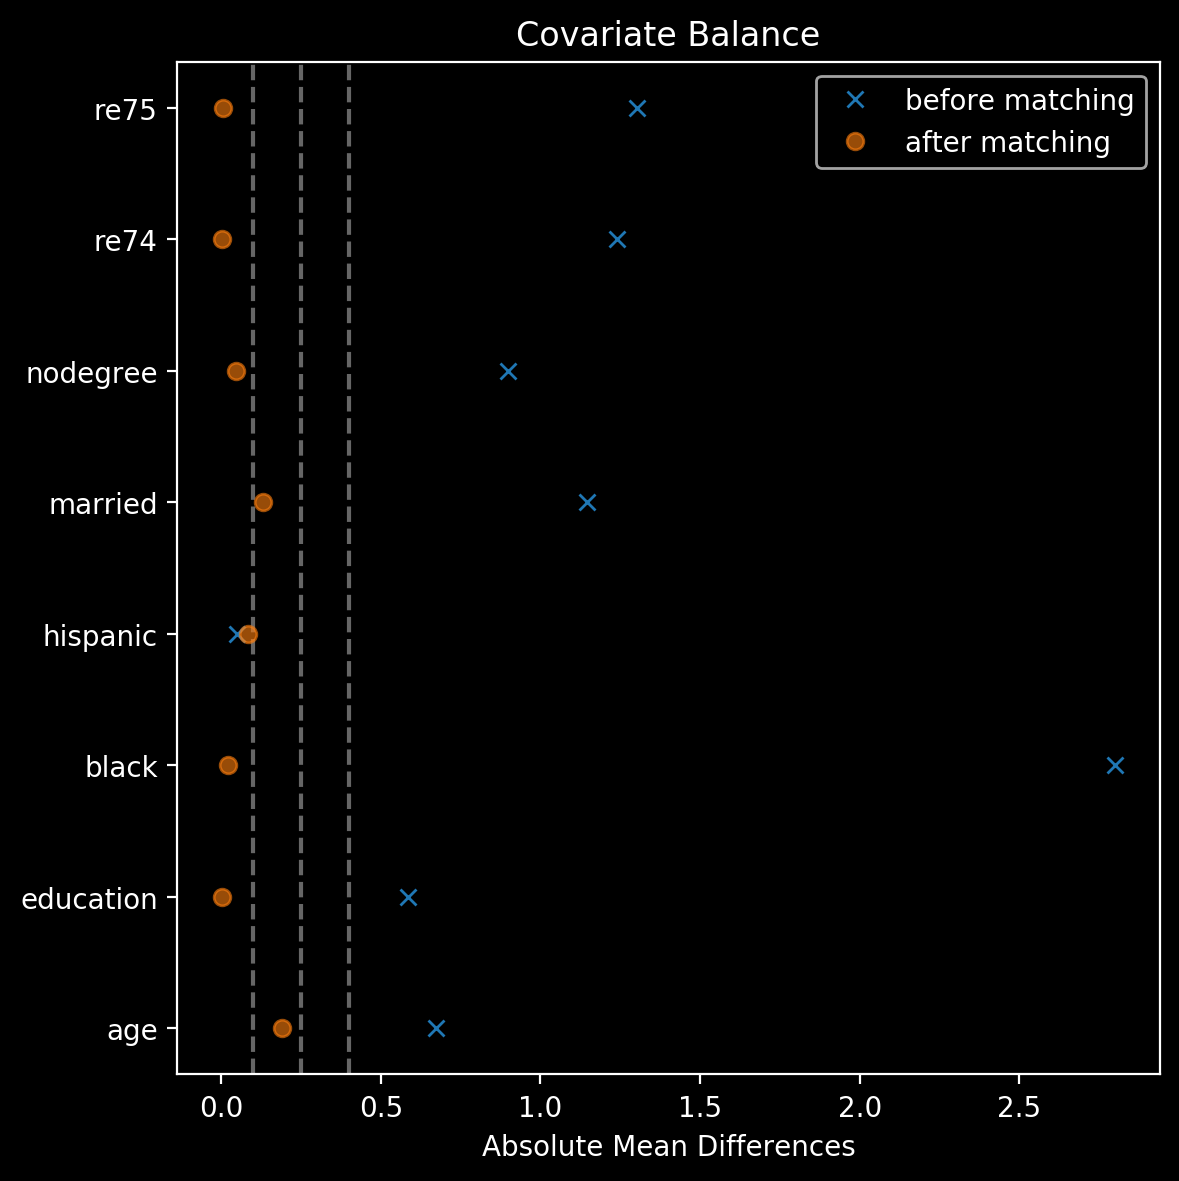

In [15]:
std_vl_mean, std_match_vl_mean, vl_mean, match_vl_mean = love_plot(nsw_plus_cps, match_df, vl, tr = tr, match_id = 'id', visual = True)